In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
%matplotlib inline

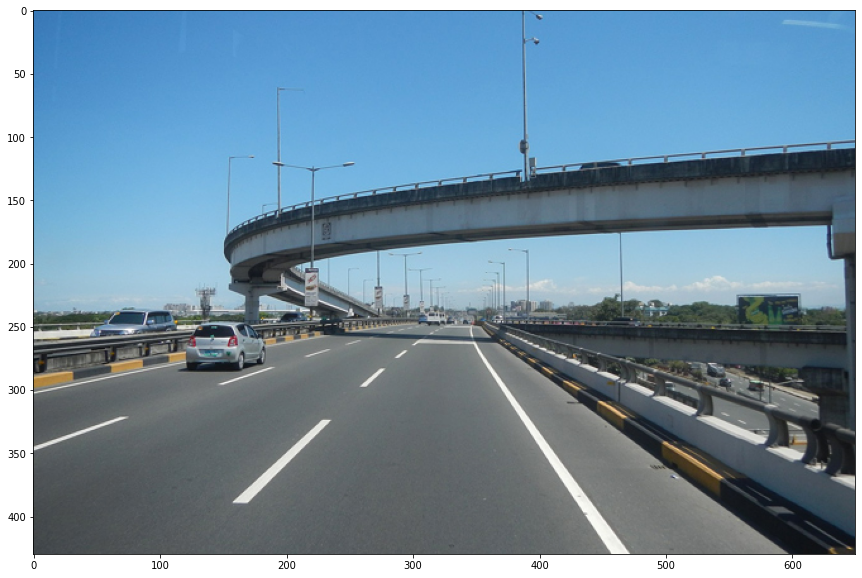

In [ ]:
# Reading the image.
img = cv2.imread('/content/drive/MyDrive/My_Data_Set/indian_5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(img);

In [ ]:
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [ ]:
gray.shape

(430, 650)

In [ ]:
# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(gray, 195, 255)

In [ ]:
img.shape

(430, 650, 3)

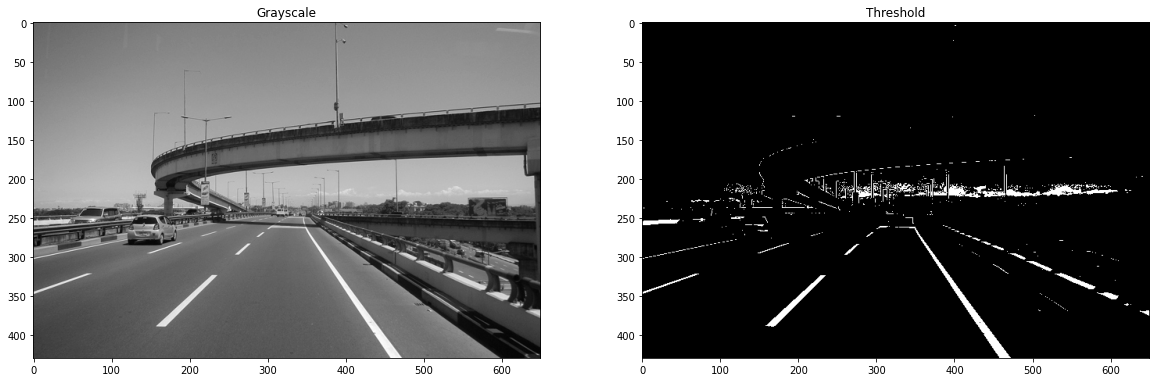

In [ ]:
# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(gray, cmap = 'gray');      plt.title('Grayscale');
plt.subplot(1,2,2); plt.imshow(threshold, cmap = 'gray'); plt.title('Threshold');

In [ ]:
threshold.shape

(430, 650)

In [ ]:
 #  Region masking: Select vertices according to the input image.
roi_vertices = np.array([[[60, 430],
                          [500, 430],
                          [390, 265],
                          [235, 265]]])

In [ ]:
# Defining a blank mask.
mask = np.zeros_like(threshold)    # create a black img with similar size of i/p img

In [ ]:
type(mask)

numpy.ndarray

In [ ]:
mask.shape

(430, 650)

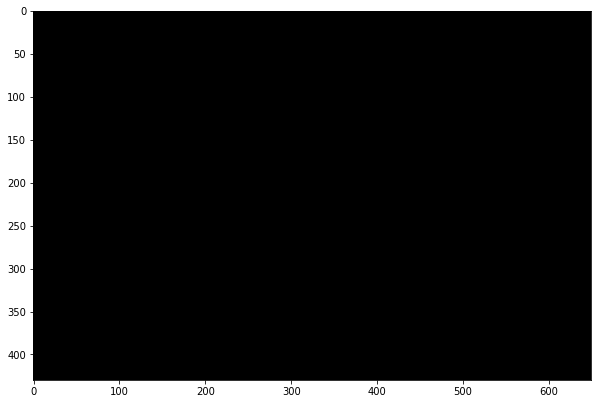

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)

In [ ]:
# Defining a 3 channel or 1 channel color to fill the mask.
if len(threshold.shape) > 2:
    channel_count = threshold.shape[2]  # 3 or 4 depending on the image.
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

In [ ]:
# Filling pixels inside the polygon.
cv2.fillPoly(mask, roi_vertices, ignore_mask_color)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Constructing the region of interest based on where mask pixels are nonzero.
roi = cv2.bitwise_and(threshold, mask)

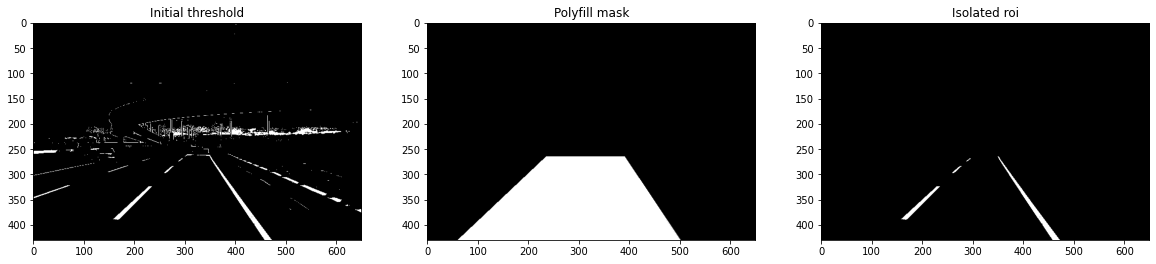

In [ ]:
# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(threshold, cmap = 'gray'); plt.title('Initial threshold')
plt.subplot(1,3,2); plt.imshow(mask, cmap = 'gray');      plt.title('Polyfill mask')
plt.subplot(1,3,3); plt.imshow(roi, cmap = 'gray');       plt.title('Isolated roi');

In [ ]:
low_threshold = 60
high_threshold = 100
edges = cv2.Canny(roi, low_threshold, high_threshold)

In [ ]:
kernel_size = 3
canny_blur = cv2.GaussianBlur(edges, (kernel_size, kernel_size), 0)

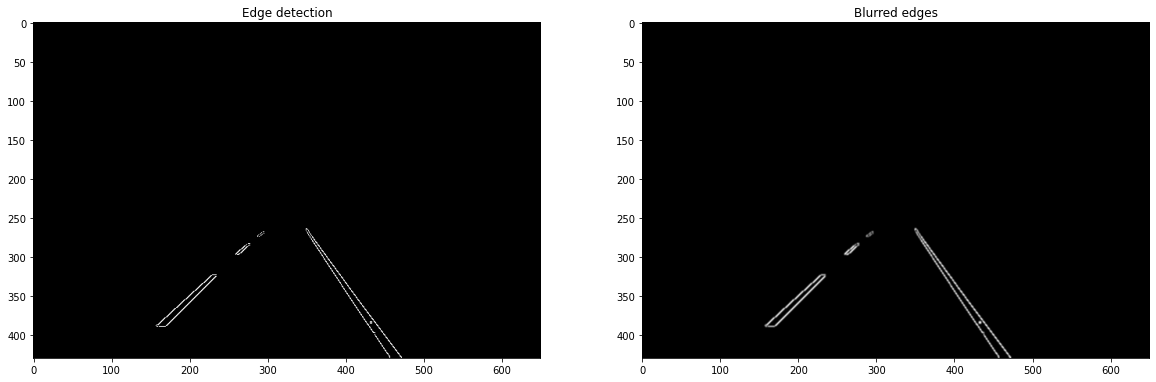

In [ ]:
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(edges, cmap = 'gray'); plt.title('Edge detection')
plt.subplot(1,2,2); plt.imshow(canny_blur, cmap = 'gray'); plt.title('Blurred edges');

In [ ]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [ ]:
# for line in lines:
#   print(line)
#   for x1,y1,x2,y2 in line:
#     # print(x1)

In [ ]:
# Hough transform parameters set according to the input image.
rho = 1
theta = np.pi / 180
threshold = 50
min_line_len = 10
max_line_gap = 20

lines = cv2.HoughLinesP(canny_blur, rho, theta, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

In [ ]:
lines

array([[[350, 263, 471, 429]],

       [[348, 265, 457, 427]],

       [[348, 263, 469, 429]],

       [[364, 293, 455, 429]],

       [[348, 267, 457, 429]],

       [[166, 390, 235, 324]],

       [[169, 390, 235, 326]],

       [[158, 390, 233, 322]],

       [[156, 389, 230, 322]],

       [[349, 266, 435, 384]],

       [[349, 263, 469, 428]],

       [[157, 389, 232, 322]],

       [[258, 296, 272, 283]],

       [[165, 390, 235, 323]],

       [[167, 390, 235, 325]],

       [[258, 297, 294, 267]],

       [[156, 387, 228, 322]],

       [[386, 311, 472, 429]],

       [[263, 298, 290, 271]],

       [[348, 264, 405, 349]],

       [[172, 389, 189, 372]]], dtype=int32)

In [ ]:
# Draw all lines found onto a new image.
hough = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)

In [ ]:
draw_lines(hough, lines)

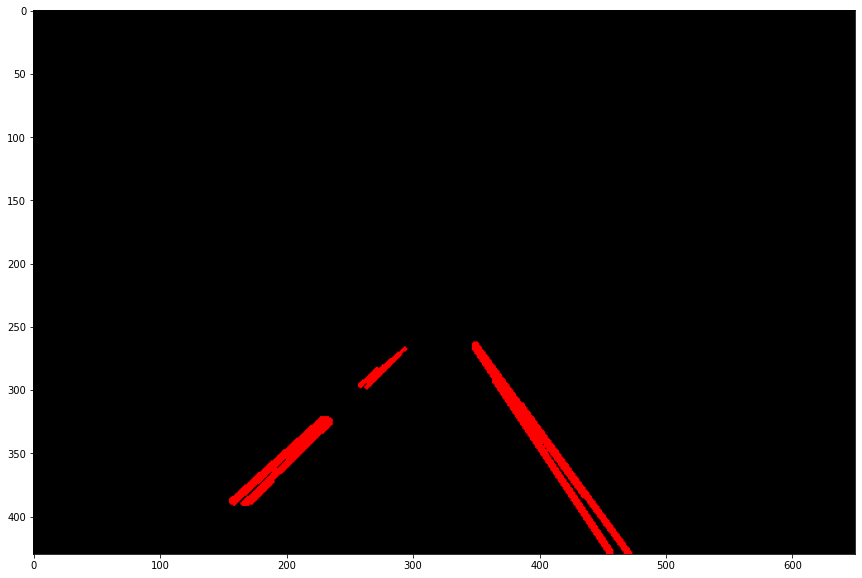

In [ ]:
# print("Found {} lines, including: {}".format(len(lines), lines[0]))
plt.figure(figsize = (15, 10));
plt.imshow(hough);

In [ ]:
def separate_left_right_lines(lines):
    """Separate left and right lines depending on the slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2: # Negative slope = left lane.
                    left_lines.append([x1, y1, x2, y2])
                elif y1 < y2: # Positive slope = right lane.
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

In [ ]:
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == 'NoneType'):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n

In [ ]:
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            print("1")
            slope = (y1-y2) / (x1-x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)
    
    # Calculate average intersection at lower_border.
    x_lane_lower_point = int((lower_border - avg_consts) / avg_slope)
    
    # Calculate average intersection at upper_border.
    x_lane_upper_point = int((upper_border - avg_consts) / avg_slope)
    
    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


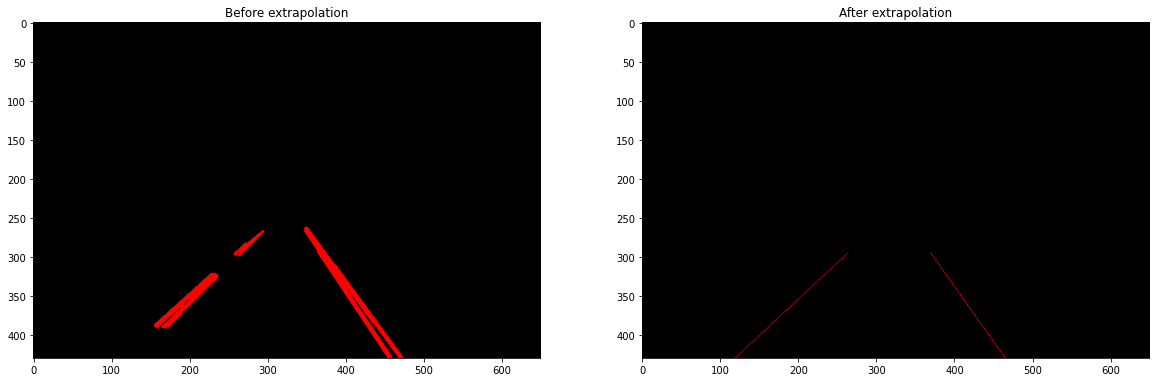

In [ ]:
# Define bounds of the region of interest.
roi_upper_border = 295
roi_lower_border = 430

# Create a blank array to contain the (colorized) results.
lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)

# Use above defined function to identify lists of left-sided and right-sided lines.
lines_left, lines_right = separate_left_right_lines(lines)

# Use above defined function to extrapolate the lists of lines into recognized lanes.
lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)
draw_lines(lanes_img, [[lane_left]], thickness = 1)
draw_lines(lanes_img, [[lane_right]], thickness = 1)

# Display results.
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(hough); ax.set_title('Before extrapolation')
ax = fig.add_subplot(1, 2, 2); plt.imshow(lanes_img); ax.set_title('After extrapolation');
plt.show()

----------------------start exp-------------------------

In [ ]:
lanes_img_1 = np.copy(lanes_img)
gray_1 = cv2.cvtColor(lanes_img_1, cv2.COLOR_BGR2GRAY)
threshold_1 = cv2.inRange(gray_1, 20, 255)

low_threshold = 50
high_threshold = 100

edges_1 = cv2.Canny(threshold_1, low_threshold, high_threshold)
kernel_size = 3
canny_blur_1 = cv2.GaussianBlur(edges_1, (kernel_size, kernel_size), 0)

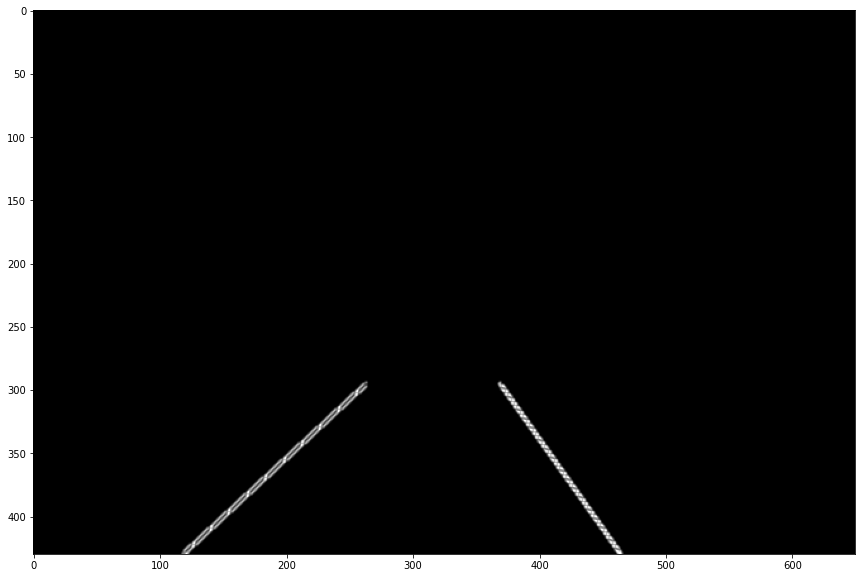

In [ ]:
plt.figure(figsize = (15, 10));
plt.imshow(canny_blur_1, cmap='gray');

In [ ]:
# Hough transform parameters set according to the input image.
rho = 1
theta = np.pi / 180
threshold = 50
min_line_len = 30
max_line_gap = 20

lines_1 = cv2.HoughLinesP(canny_blur_1, rho, theta, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

In [ ]:
my_list = []
for line_1 in lines_1:
  for x1, y1, x2, y2 in line_1:
    first_tup = [x1, y1]
    second_tup = [x2, y2]
    my_list.append(tuple(first_tup))
    my_list.append(tuple(second_tup))

In [ ]:
for c_var in my_list:
  # print(c_var)
  cv2.circle(lanes_img_1, c_var, 1, (0, 0, 255) ,-1)

In [ ]:
lines_1

array([[[118, 429, 264, 293]],

       [[367, 294, 465, 429]],

       [[120, 429, 264, 294]],

       [[122, 429, 264, 297]],

       [[367, 296, 464, 429]],

       [[117, 428, 260, 294]],

       [[368, 294, 466, 429]],

       [[369, 293, 465, 426]],

       [[369, 300, 462, 429]],

       [[370, 293, 447, 400]],

       [[123, 429, 264, 298]],

       [[121, 429, 264, 296]],

       [[403, 348, 461, 429]],

       [[117, 429, 263, 293]]], dtype=int32)

**Section Formula To Get Points**

In [ ]:
def sec_cal(x1, y1, x2, y2, sec_pts):
  point_list = []
  m = 1
  n = sec_pts
  for _ in range(sec_pts):
    # print(f'm---->{m} and n--->{n}')
    X = int(((m*x2) + (n*x1))/(m+n))
    Y = int(((m*y2) + (n*y1))/(m+n))
    tup_pt = [X,Y]
    point_list.append(tuple(tup_pt))
    m = m+1
    n = n - 1
  
  return point_list

In [ ]:
my_pts = sec_cal(369, 300, 462, 429, 10)

In [ ]:
my_pts

[(377, 311),
 (385, 323),
 (394, 335),
 (402, 346),
 (411, 358),
 (419, 370),
 (428, 382),
 (436, 393),
 (445, 405),
 (453, 417)]

In [ ]:
for t in my_pts:
  cv2.circle(lanes_img_1, t, 3, (0, 0, 255) ,-1)

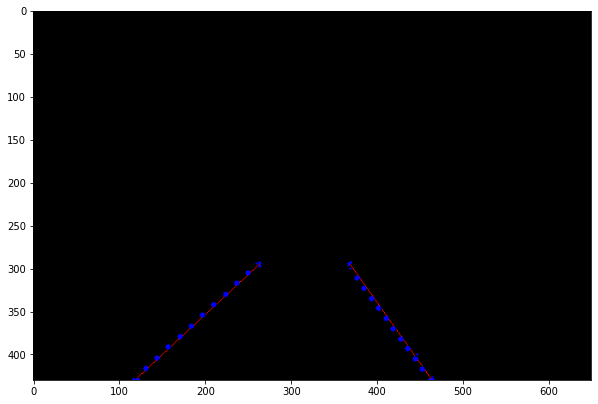

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(lanes_img_1);

**Section Formula To Get Points**

In [ ]:
alpha = 0.8
beta = 1.0
gamma = 0.0
image_annotated = cv2.addWeighted(img, alpha, lanes_img_1, beta, gamma)

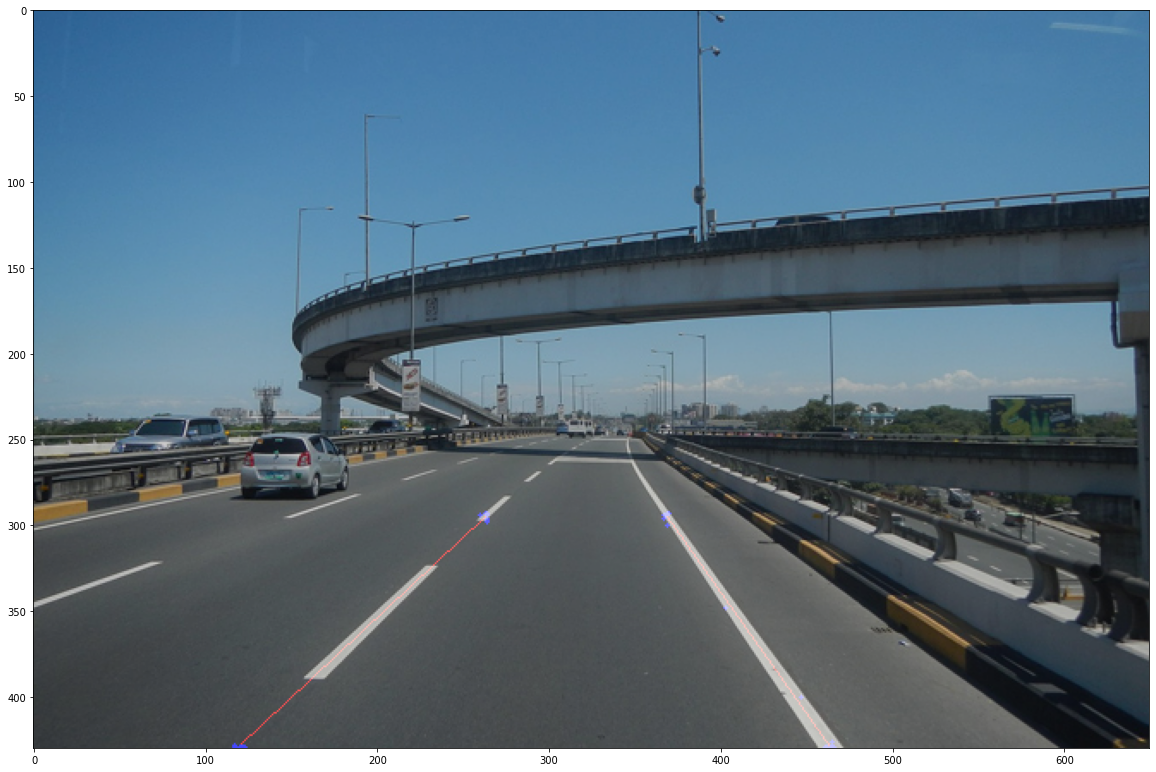

In [ ]:
# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)

----------------------end exp-------------------------

In [ ]:
alpha = 0.8
beta = 1.0
gamma = 0.0
image_annotated = cv2.addWeighted(img, alpha, lanes_img, beta, gamma)

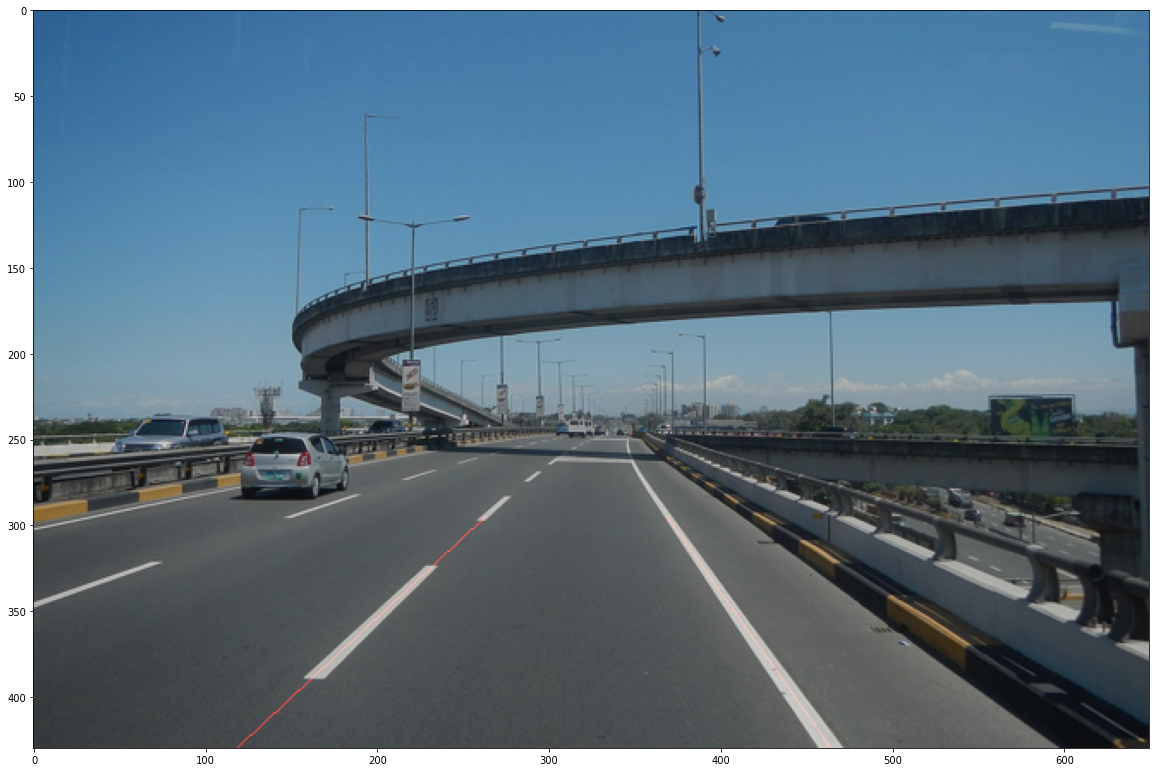

In [ ]:
# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)

In [ ]:
# image_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB)
# cv2.imwrite('./Lane1ee-image.jpg', image_annotated);